# Φ-Flow Fluid Simulation (Colab Version)

Runs a 2D smoke simulation with two dye inflows, then computes a gradient-based optimization to separate the dyes into their target regions using controllable jets.

**Run cells in order.** Animation will display inline.

## 1. Install Dependencies

In [25]:
!pip install phiflow matplotlib numpy

## 2. Imports

In [26]:
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for Colab

from phi.torch.flow import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import numpy as np

plt.close("all")

## 3. Setup - Inflows, Regions, Jets

In [27]:
# Build two inflow sources: left-middle and right-middle of the domain.
def make_inflow_A():
    return 0.6 * CenteredGrid(
        Box(vec(x=6, y=0), vec(x=10, y=4)),
        extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
    )

def make_inflow_B():
    return 0.6 * CenteredGrid(
        Box(vec(x=22, y=0), vec(x=26, y=4)),
        extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
    )


INFLOW_A = make_inflow_A()
INFLOW_B = make_inflow_B()

# Region masks: right half for dye_A, left half for dye_B.
REGION_A = CenteredGrid(
    Box(vec(x=16, y=0), vec(x=32, y=40)),
    extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)
REGION_B = CenteredGrid(
    Box(vec(x=0, y=0), vec(x=16, y=40)),
    extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)

# Define two jet masks as thin rectangles near left/right walls at mid-height.
JET_L = CenteredGrid(
    Box(vec(x=1, y=16), vec(x=3, y=26)),
    extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)
JET_R = CenteredGrid(
    Box(vec(x=29, y=16), vec(x=31, y=26)),
    extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40),
)

print("Inflows and regions initialized.")

Inflows and regions initialized.


## 4. Control Parameters

In [28]:
# Jet action tensors: differentiable time-series controls.
# Left jet blows +x (right), right jet blows -x (left).
NUM_STEPS = 80
CONTROL_START = 10  # timestep when jet control kicks in

# Precomputed control mask: 0 before CONTROL_START, 1 after
control_mask = math.tensor(
    [0.0 if t < CONTROL_START else 1.0 for t in range(NUM_STEPS)],
    batch('time')
)

# Inflow fill phase: inflow active for t < FILL_END, then stops
FILL_END = 5  # timestep when inflow stops
inflow_mask = math.tensor(
    [1.0 if t < FILL_END else 0.0 for t in range(NUM_STEPS)],
    batch('time')
)

# Unconstrained parameters for optimization (will be mapped through tanh)
uL = math.zeros(batch(time=NUM_STEPS))
uR = math.zeros(batch(time=NUM_STEPS))

# Maximum jet strength (bounded via tanh)
A_MAX = 1000.0

# Diagnostic: check inflow masses for discretization differences.
print("inflow_A_mass_per_step:", math.sum(INFLOW_A.values))
print("inflow_B_mass_per_step:", math.sum(INFLOW_B.values))

inflow_A_mass_per_step: 9.6
inflow_B_mass_per_step: 9.6


## 5. Physics Step Function

In [29]:
def advect_maccormack_raw(dye: CenteredGrid, velocity: StaggeredGrid, dt=1):
    # Predictor
    pred = advect.semi_lagrangian(dye, velocity, dt=dt)

    # Backward step (try negative dt; fallback to -velocity)
    try:
        back = advect.semi_lagrangian(pred, velocity, dt=-dt)
    except Exception:
        back = advect.semi_lagrangian(pred, -velocity, dt=dt)

    # Raw correction (NO limiter / clamp)
    return pred + 0.5 * (dye - back)

def step(dye_A: CenteredGrid, dye_B: CenteredGrid, velocity: StaggeredGrid,
         aL_t: float, aR_t: float, inflow_scale=1.0):
    """Perform one physics timestep including advection, buoyancy, and projection."""
    # Use unclamped MacCormack
    dye_A = advect_maccormack_raw(dye_A, velocity, dt=1) + inflow_scale * INFLOW_A
    dye_B = advect_maccormack_raw(dye_B, velocity, dt=1) + inflow_scale * INFLOW_B

    total = dye_A + dye_B
    buoyancy_force = (total * vec(x=0, y=0.5)) @ velocity
    jet_force_centered = (aL_t * JET_L - aR_t * JET_R) * vec(x=1, y=0)
    velocity = velocity + (buoyancy_force + jet_force_centered @ velocity)
    velocity = advect.semi_lagrangian(velocity, velocity, dt=1)
    velocity, _ = fluid.make_incompressible(
        velocity, (),
        Solve(rel_tol=1e-3, abs_tol=1e-3, max_iterations=1000, rank_deficiency=0)
    )
    return dye_A, dye_B, velocity

## 6. Rollout Function

In [30]:
def rollout(dye_A0: CenteredGrid, dye_B0: CenteredGrid, vel0: StaggeredGrid,
            actions_L, actions_R, print_mass=False, debug=False):
    """Roll out a trajectory and stack dye frames over time for visualization."""
    steps = actions_L.shape.get_size('time')
    frames_A = [dye_A0]
    frames_B = [dye_B0]
    dye_A, dye_B, vel = dye_A0, dye_B0, vel0

    for t in range(steps):
        # Use precomputed mask: 0 before CONTROL_START, 1 after
        mask_t = control_mask.time[t]
        aL_t = mask_t * A_MAX * math.tanh(actions_L.time[t])
        aR_t = mask_t * A_MAX * math.tanh(actions_R.time[t])

        if debug and t == CONTROL_START:
            print(f"ASSERT t={t}: uL.time[t]={actions_L.time[t]}, "
                  f"tanh(uL.time[t])={math.tanh(actions_L.time[t])}, aL_t={aL_t}")

        # Get inflow scale for this timestep (1.0 before FILL_END, 0.0 after)
        inflow_t = inflow_mask.time[t]

        # Debug: verify inflow mask is actually being applied
        if debug and t in [FILL_END-1, FILL_END, FILL_END+1, FILL_END+5]:
            print("t", t, "inflow_t", float(inflow_t.native()))
            addA = math.sum((inflow_t * INFLOW_A).values)
            addB = math.sum((inflow_t * INFLOW_B).values)
            print("   addedA", float(addA.native()), "addedB", float(addB.native()))

        # --- DIAGNOSTIC CALLS ---
        # Run diagnostic periodically if debug is on
        if debug and t % 10 == 0:
             if 'log_maccormack_mass_breakdown' in globals():
                 log_maccormack_mass_breakdown(dye_A, vel, label=f"t={t} A")
                 log_maccormack_mass_breakdown(dye_B, vel, label=f"t={t} B")

        dye_A, dye_B, vel = step(dye_A, dye_B, vel, aL_t, aR_t, inflow_scale=inflow_t)

        # Sanity check for negative dye values
        if debug and t % 10 == 0:
            minA = math.min(dye_A.values); minB = math.min(dye_B.values)
            maxA = math.max(dye_A.values); maxB = math.max(dye_B.values)
            print(f"t={t}: minA={float(minA.native())}, maxA={float(maxA.native())}, "
                  f"minB={float(minB.native())}, maxB={float(maxB.native())}")

        # Detect NaNs early (only in debug mode to avoid tensor->float during grad)
        if debug:
            vmax = math.max(math.abs(vel.values))
            vmax_f = float(vmax.native().detach())
            if vmax_f != vmax_f:  # NaN check
                print(f"NaN vel at t={t}, aL_t={aL_t}, aR_t={aR_t}")
                break

        frames_A.append(dye_A)
        frames_B.append(dye_B)

        # Diagnostic print for timesteps around CONTROL_START (after step)
        if debug and CONTROL_START - 2 <= t <= CONTROL_START + 10:
            vel_comp_max = math.max(math.abs(vel.values))
            mass_A = math.sum(dye_A.values)
            mass_B = math.sum(dye_B.values)
            print(f"t={t}: aL_t={aL_t}, aR_t={aR_t}, vel_comp_max={vel_comp_max:.4f}, "
                  f"mass_A={mass_A:.4f}, mass_B={mass_B:.4f}")

        # Print mass every 10 timesteps
        if print_mass and (t + 1) % 10 == 0:
            mass_A = math.sum(dye_A.values)
            mass_B = math.sum(dye_B.values)
            total_mass = mass_A + mass_B
            print(f"Timestep {t + 1}: mass_A = {mass_A:.4f}, mass_B = {mass_B:.4f}, "
                  f"total = {total_mass:.4f}")

    traj_A = field.stack(frames_A, batch('traj_time'))
    traj_B = field.stack(frames_B, batch('traj_time'))
    return traj_A, traj_B, dye_A, dye_B

## 7. Loss Function

In [31]:
def compute_loss(actions_L, actions_R):
    """Run simulation and compute loss = -purity (to maximize separation)."""
    _traj_A, _traj_B, final_A, final_B = rollout(
        initial_dye_A, initial_dye_B, initial_velocity,
        actions_L, actions_R,
        print_mass=False,
        debug=False  # Changed back to False
    )

    # Compute mass in correct region vs wrong region.
    A_in_A = math.sum((final_A * REGION_A).values)
    B_in_B = math.sum((final_B * REGION_B).values)
    A_in_B = math.sum((final_A * REGION_B).values)
    B_in_A = math.sum((final_B * REGION_A).values)

    correct = A_in_A + B_in_B
    wrong = A_in_B + B_in_A
    purity = correct / (correct + wrong + 1e-8)

    loss = -purity  # minimize negative purity = maximize purity
    return loss


def objective(uL, uR):
    """Objective wrapper for gradient computation."""
    return compute_loss(uL, uR)

## 8. Initialize Fields and Run Optimization Step

In [32]:
initial_dye_A = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))
initial_dye_B = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=32, y=40))
initial_velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=32, y=40))

# Gradient descent on actions.
lr = 1e-3
grad_fn = math.gradient(objective, wrt='uL,uR', get_output=True)

print("Initial loss:", compute_loss(uL, uR))
print("Sanity forward loss (no grad):", compute_loss(uL, uR))

(loss, (d_uL, d_uR)) = grad_fn(uL, uR)

Initial loss: 0.049001355
Sanity forward loss (no grad): 0.049001355


## 9. Visualize Gradients

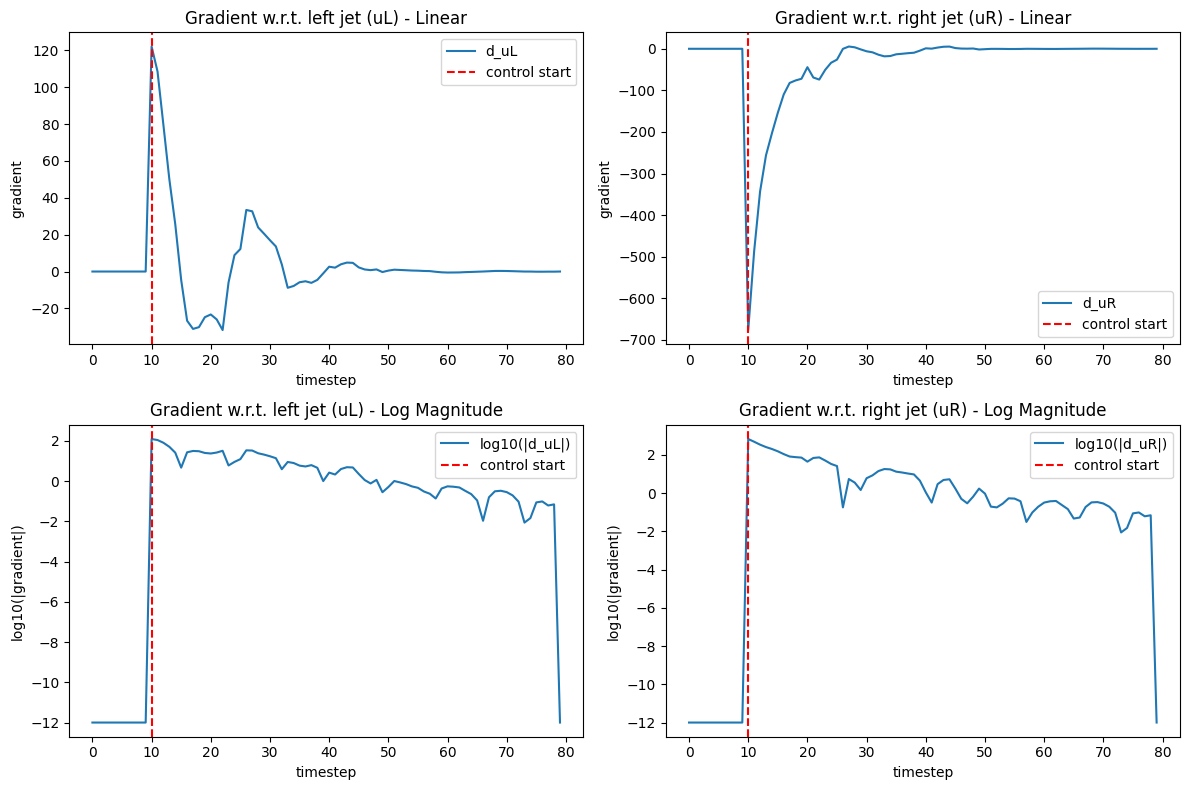

In [33]:
fig_grad, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(2, 2, figsize=(12, 8))
timesteps = list(range(NUM_STEPS))

# Top row: linear gradients
ax1.plot(timesteps, d_uL.native('time').detach().cpu().numpy(), label='d_uL')
ax1.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax1.set_xlabel('timestep')
ax1.set_ylabel('gradient')
ax1.set_title('Gradient w.r.t. left jet (uL) - Linear')
ax1.legend()

ax2.plot(timesteps, d_uR.native('time').detach().cpu().numpy(), label='d_uR')
ax2.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax2.set_xlabel('timestep')
ax2.set_ylabel('gradient')
ax2.set_title('Gradient w.r.t. right jet (uR) - Linear')
ax2.legend()

# Bottom row: log magnitude
gL_native = d_uL.native('time').detach().cpu().numpy()
gR_native = d_uR.native('time').detach().cpu().numpy()
gL = np.abs(gL_native)
gR = np.abs(gR_native)

ax1b.plot(timesteps, np.log10(gL + 1e-12), label='log10(|d_uL|)')
ax1b.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax1b.set_xlabel('timestep')
ax1b.set_ylabel('log10(|gradient|)')
ax1b.set_title('Gradient w.r.t. left jet (uL) - Log Magnitude')
ax1b.legend()

ax2b.plot(timesteps, np.log10(gR + 1e-12), label='log10(|d_uR|)')
ax2b.axvline(x=CONTROL_START, color='r', linestyle='--', label='control start')
ax2b.set_xlabel('timestep')
ax2b.set_ylabel('log10(|gradient|)')
ax2b.set_title('Gradient w.r.t. right jet (uR) - Log Magnitude')
ax2b.legend()

fig_grad.tight_layout()
display(fig_grad)
plt.close(fig_grad)

In [34]:
# --- MacCormack clamp diagnostic helpers ---

def _to_float(x):
    # x is a Φ tensor
    return float(x.native().detach().cpu())

def dye_mass(dye: CenteredGrid):
    return _to_float(math.sum(dye.values))

def _semi_lagrangian_backward(field, velocity, dt=1):
    # Most PhiFlow builds accept negative dt. If yours doesn't, fall back to -velocity.
    try:
        return advect.semi_lagrangian(field, velocity, dt=-dt)
    except Exception:
        return advect.semi_lagrangian(field, -velocity, dt=dt)

def mac_cormack_unclamped(dye: CenteredGrid, velocity: StaggeredGrid, dt=1):
    """
    Standard MacCormack/BFECC-style correction WITHOUT any limiter/clamp.
    Returns (pred, back, unclamped).
    """
    pred = advect.semi_lagrangian(dye, velocity, dt=dt)
    back = _semi_lagrangian_backward(pred, velocity, dt=dt)
    unclamped = pred + 0.5 * (dye - back)
    return pred, back, unclamped

def mac_cormack_clamped(dye: CenteredGrid, velocity: StaggeredGrid, dt=1):
    """
    PhiFlow's MacCormack, which includes the limiter/clamp.
    """
    return advect.mac_cormack(dye, velocity, dt=dt)

def log_maccormack_mass_breakdown(dye: CenteredGrid, velocity: StaggeredGrid, label="dye", dt=1):
    """
    Prints the mass change attributable to:
      - predictor diffusion (semi-lagrangian)
      - the raw correction
      - the nonlinear clamp/limiter
    """
    S0 = dye_mass(dye)
    pred, back, un = mac_cormack_unclamped(dye, velocity, dt=dt)
    cl = mac_cormack_clamped(dye, velocity, dt=dt)

    Sp = dye_mass(pred)
    Su = dye_mass(un)
    Sc = dye_mass(cl)

    # This is the key number: + means the clamp increased total mass vs the raw corrected field.
    clamp_delta = Sc - Su

    # Optional: how much the correction itself changed mass vs predictor
    corr_delta = Su - Sp
    pred_delta = Sp - S0

    print(f"[{label}] Mass: {S0:.4f} -> Pred: {Sp:.4f} -> Unclamped: {Su:.4f} -> Clamped: {Sc:.4f}")
    print(f"    Deltas: SL={pred_delta:+.4f}, Corr={corr_delta:+.4f}, Clamp={clamp_delta:+.4f}")

## 10. Update Controls

In [35]:
# Clip gradients before update
CLIP = 100.0
d_uL = math.clip(d_uL, -CLIP, CLIP)
d_uR = math.clip(d_uR, -CLIP, CLIP)

uL = uL - lr * d_uL
uR = uR - lr * d_uR

print("After 1 step, loss:", compute_loss(uL, uR))

After 1 step, loss: -0.29059458


## 11. Run Simulation for Visualization

In [36]:
print("--- Mass tracking every 10 timesteps ---")
traj_A, traj_B, final_A, final_B = rollout(
    initial_dye_A, initial_dye_B, initial_velocity,
    uL, uR, print_mass=True, debug=True
)

--- Mass tracking every 10 timesteps ---
[t=0 A] Mass: 0.0000 -> Pred: 0.0000 -> Unclamped: 0.0000 -> Clamped: 0.0000
    Deltas: SL=+0.0000, Corr=+0.0000, Clamp=+0.0000
[t=0 B] Mass: 0.0000 -> Pred: 0.0000 -> Unclamped: 0.0000 -> Clamped: 0.0000
    Deltas: SL=+0.0000, Corr=+0.0000, Clamp=+0.0000
t=0: minA=0.0, maxA=0.6000000238418579, minB=0.0, maxB=0.6000000238418579
t 4 inflow_t 1.0
   addedA 9.600000381469727 addedB 9.600000381469727
t 5 inflow_t 0.0
   addedA 0.0 addedB 0.0
t 6 inflow_t 0.0
   addedA 0.0 addedB 0.0
t=8: aL_t=0.0, aR_t=0.0, vel_comp_max=2.1763177, mass_A=53.110523, mass_B=53.11052
t=9: aL_t=0.0, aR_t=0.0, vel_comp_max=2.2445593, mass_A=54.28302, mass_B=54.283012
Timestep 10: mass_A = 54.28302, mass_B = 54.283012, total = 108.56603
ASSERT t=10: uL.time[t]=-0.1, tanh(uL.time[t])=-0.099668, aL_t=-99.66801
t 10 inflow_t 0.0
   addedA 0.0 addedB 0.0
[t=10 A] Mass: 54.2830 -> Pred: 56.0439 -> Unclamped: 55.4622 -> Clamped: 55.0413
    Deltas: SL=+1.7609, Corr=-0.5817, C

In [37]:
# Reset controls to zero to turn off jets
uL = math.zeros(batch(time=NUM_STEPS))
uR = math.zeros(batch(time=NUM_STEPS))
print("Jets turned off (uL and uR reset to zeros).")

Jets turned off (uL and uR reset to zeros).


## 12. Create and Display Animation

In [38]:
# Animate the simulation using Phi-Flow's built-in visualization
traj_combined = field.stack([traj_A, traj_B], batch('dye'))
vis.plot(traj_combined, animate='traj_time')

## 13. (Optional) Save Animation to File

In [39]:
# Uncomment to save as GIF (requires pillow)
# anim.save('simulation.gif', writer='pillow', fps=10)
# print("Saved animation to simulation.gif")

# Uncomment to save as MP4 (requires ffmpeg)
# anim.save('simulation.mp4', writer='ffmpeg', fps=10)
# print("Saved animation to simulation.mp4")

# To download from Colab:
# from google.colab import files
# files.download('simulation.gif')

## 14. Display Final State as Static Image

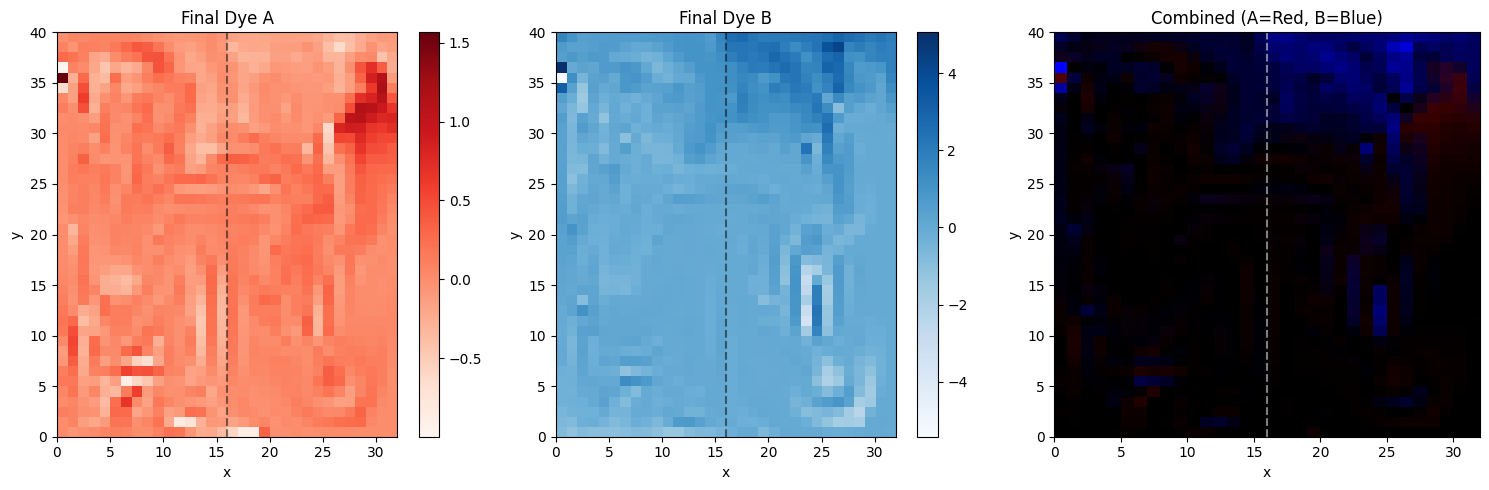


Done!


In [40]:
fig_final, axes = plt.subplots(1, 3, figsize=(15, 5))

# Final dye A
A_final = final_A.values.native('y,x').detach().cpu().numpy()
im0 = axes[0].imshow(A_final, origin='lower', extent=[0, 32, 0, 40],
                      cmap='Reds', aspect='auto')
axes[0].set_title('Final Dye A')
axes[0].axvline(x=16, color='black', linestyle='--', alpha=0.5)
plt.colorbar(im0, ax=axes[0])

# Final dye B
B_final = final_B.values.native('y,x').detach().cpu().numpy()
im1 = axes[1].imshow(B_final, origin='lower', extent=[0, 32, 0, 40],
                      cmap='Blues', aspect='auto')
axes[1].set_title('Final Dye B')
axes[1].axvline(x=16, color='black', linestyle='--', alpha=0.5)
plt.colorbar(im1, ax=axes[1])

# Combined view
max_val = max(np.max(A_final), np.max(B_final), 1e-6)
rgb_final = np.stack([
    np.clip(A_final / max_val, 0, 1),
    np.zeros_like(A_final),
    np.clip(B_final / max_val, 0, 1)
], axis=-1)
axes[2].imshow(rgb_final, origin='lower', extent=[0, 32, 0, 40], aspect='auto')
axes[2].set_title('Combined (A=Red, B=Blue)')
axes[2].axvline(x=16, color='white', linestyle='--', alpha=0.5)

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

fig_final.tight_layout()
display(fig_final)
plt.close(fig_final)

print("\nDone!")